In [1]:

from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
#Use inspector to fetch columns from Measurement
inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
#Select top 5 records from Measurement
engine.execute('SELECT * FROM Measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [12]:
#Fetch last_year
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(last_year)

('2017-08-23',)
2016-08-23


In [14]:
#Design a query to retrieve the last 12 months of precipitation data.
results = session.query(Measurement.prcp,Measurement.date).\
    filter(Measurement.date >= last_year).all()
#Load the query results into a Pandas DataFrame and set the index to the date column.
prcp_results=pd.DataFrame(results)
prcp_results.columns = ["prcp", "date"]
prcp_results.set_index('date', inplace=True)
prcp_results.head()

,prcp
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


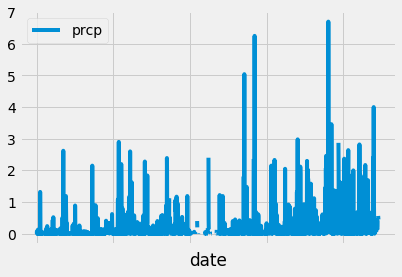

In [55]:
prcp_results.plot()
plt.savefig("prcp_analysis.png")

In [56]:
prcp=pd.DataFrame(prcp_results['prcp'].describe())
prcp

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [73]:
#Fetch columns in station
inspector = inspect(engine)
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [18]:
# How many stations are available in this dataset?

locations = session.query(Measurement).group_by(Measurement.station).count()
print("There are {} stations.".format(locations))

There are 9 stations.


In [27]:
#Design a query to find the most active stations.
#List the stations and observation counts in descending order.
station_count=session.query(Measurement.station,func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

    


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [158]:
# What are the most active stations?
# List the stations and the counts in descending order
active_station=engine.execute('SELECT station,MAX(num_stations) FROM (SELECT station, COUNT(station) AS num_stations FROM Measurement GROUP BY station) AS count').fetchall() 
active_station[0][0]

    

'USC00519281'

In [159]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs),\
             func.max(Measurement.tobs),func.avg(Measurement.tobs)).group_by(Measurement.station).\
           order_by(func.count(Measurement.id).desc()).first()


[(54.0, 85.0, 71.66378066378067)]

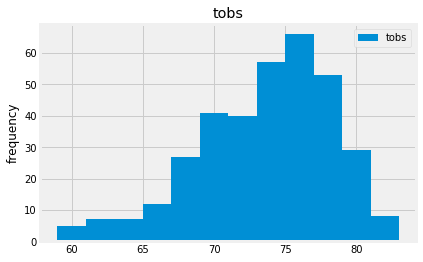

In [40]:
#results=engine.execute('SELECT tobs FROM Measurement where date > "2017-06-03" and station = "USC00519281" ').fetchall()
temp=session.query(Measurement.tobs, Measurement.station).\
filter(Measurement.date >='2016-08-23', Measurement.date <='2017-08-23').\
filter(Measurement.station=='USC00519281').\
order_by(Measurement.date).statement
prcp_results = pd.read_sql(temp, engine).dropna()
prcp_results.head(5)
prcp_results.hist(bins=12,label='tobs')
plt.ylabel('frequency')
plt.legend(loc='upper right')
plt.savefig("Temp_analysis.png")
